In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


### Data Preparation/ Data Cleaning



In [26]:
df = pd.read_csv("sources/vehicles.csv", nrows=10000,index_col=0)
df.tail()

,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
id,,,,,,,,,,,,,,,,,,,,,
7316825923,https://phoenix.craigslist.org/evl/ctd/d/mesa-...,phoenix,https://phoenix.craigslist.org,15999,2015.0,gmc,acadia sle-1,good,6 cylinders,gas,...,full-size,SUV,red,https://images.craigslist.org/00Y0Y_iukNOte9S5...,2015 GMC Acadia SLE-1 Financing Available!!! 6...,NaN,az,33.415592,-111.657979,2021-05-04T10:48:28-0700
7316825904,https://phoenix.craigslist.org/evl/ctd/d/mesa-...,phoenix,https://phoenix.craigslist.org,6999,2012.0,ford,focus sel hatchback,good,4 cylinders,gas,...,mid-size,hatchback,silver,https://images.craigslist.org/00i0i_kWRkjnGmCZ...,2012 Ford Focus SEL Hatchback Loaded!!! 4 CYL ...,NaN,az,33.415592,-111.657937,2021-05-04T10:48:27-0700
7316825646,https://phoenix.craigslist.org/evl/ctd/d/mesa-...,phoenix,https://phoenix.craigslist.org,24999,2015.0,ram,1500 big horn,good,8 cylinders,gas,...,full-size,pickup,silver,https://images.craigslist.org/00l0l_9KhJhGzJE5...,2015 Ram 1500 Quad Cab Big Horn HEMI!!! 8 CYL ...,NaN,az,33.415592,-111.657915,2021-05-04T10:48:02-0700
7316825626,https://phoenix.craigslist.org/evl/ctd/d/mesa-...,phoenix,https://phoenix.craigslist.org,7999,2011.0,ford,fusion sel,good,4 cylinders,gas,...,full-size,sedan,grey,https://images.craigslist.org/00101_az5R00dbXW...,2011 Ford Fusion SEL Nicely Loaded!!! 4 CYL En...,NaN,az,33.415628,-111.657958,2021-05-04T10:48:00-0700
7316825372,https://phoenix.craigslist.org/evl/ctd/d/mesa-...,phoenix,https://phoenix.craigslist.org,10999,2012.0,chrysler,200 s convertible,like new,6 cylinders,gas,...,mid-size,convertible,white,https://images.craigslist.org/00Y0Y_dm8XwXGMb9...,2012 Chrysler 200 S Hard Top Convertible Nicel...,NaN,az,33.415628,-111.657894,2021-05-04T10:47:36-0700


In [27]:

df = df.dropna(subset=["model", "odometer", "year","price"]).copy()
df= df[df['price'] > 100]

CAT_FEATURES = [ "manufacturer", "model",  "condition", "cylinders","fuel","title_status","transmission", "drive", "size", "type", "paint_color"]
NUM_FEATURES = ["odometer", "year"]

for cat in CAT_FEATURES:
    df[cat] = df[cat].str.strip().str.replace(' ', '_').str.replace('-', '_').str.lower() 
y = np.log1p(df["price"])                            
X = df[CAT_FEATURES + NUM_FEATURES]



In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### EDA (Exploratory Data Analysis)


In [29]:


for col in X_train[CAT_FEATURES].columns:
    print(f"{X_train[col].value_counts()}")


manufacturer
ford               1307
chevrolet          1140
toyota              569
jeep                378
nissan              364
honda               312
ram                 292
gmc                 289
dodge               267
bmw                 211
kia                 208
subaru              168
mercedes_benz       154
lexus               148
hyundai             148
acura               133
volkswagen          133
cadillac            132
chrysler            113
audi                102
infiniti             97
buick                97
lincoln              81
mazda                79
volvo                61
jaguar               43
mitsubishi           41
mini                 37
rover                34
pontiac              32
alfa_romeo           27
porsche              17
tesla                16
fiat                 15
mercury              15
saturn               11
harley_davidson       4
ferrari               2
Name: count, dtype: int64
model
f_150                    184
silverado_1500

In [30]:
X_train.tail()

,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,odometer,year
id,,,,,,,,,,,,,
7311609133,ram,1500,NaN,8_cylinders,gas,clean,automatic,4wd,NaN,truck,NaN,80251.0,2013.0
7314448668,mini,cooper_john_cooper_works,excellent,NaN,gas,clean,manual,NaN,NaN,NaN,green,48000.0,2016.0
7313493079,honda,odyssey_ex_l,excellent,6_cylinders,gas,clean,automatic,fwd,NaN,mini_van,grey,18044.0,2018.0
7310403124,hyundai,elantra,NaN,4_cylinders,gas,clean,other,fwd,NaN,sedan,black,71224.0,2018.0
7315907177,honda,odyssey,good,NaN,gas,salvage,manual,rwd,NaN,mini_van,silver,137260.0,2005.0


In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 7310912324 to 7315907177
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  7277 non-null   object 
 1   model         7546 non-null   object 
 2   condition     4090 non-null   object 
 3   cylinders     5066 non-null   object 
 4   fuel          7477 non-null   object 
 5   title_status  7412 non-null   object 
 6   transmission  7500 non-null   object 
 7   drive         5406 non-null   object 
 8   size          1955 non-null   object 
 9   type          6210 non-null   object 
 10  paint_color   6063 non-null   object 
 11  odometer      7546 non-null   float64
 12  year          7546 non-null   float64
dtypes: float64(2), object(11)
memory usage: 825.3+ KB


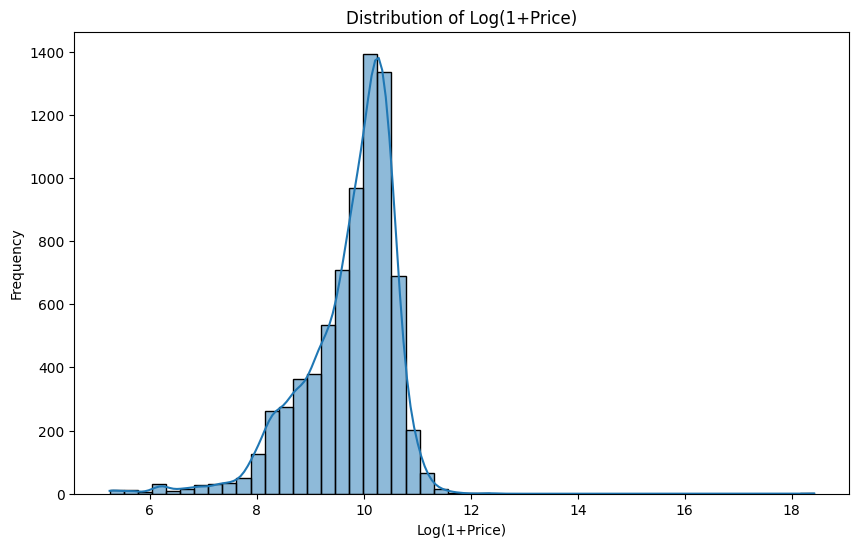

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribution of Log(1+Price)')
plt.xlabel('Log(1+Price)')
plt.ylabel('Frequency')
plt.show()

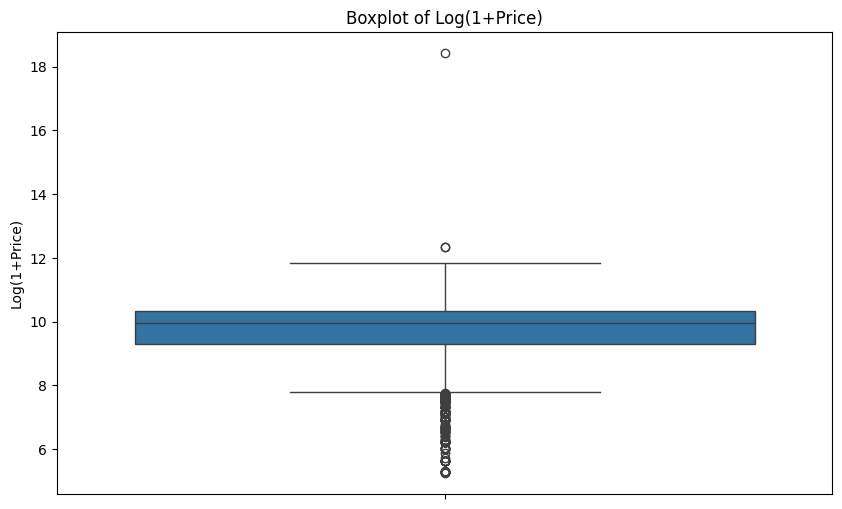

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(y_train)
plt.title('Boxplot of Log(1+Price)')
plt.ylabel('Log(1+Price)')
plt.show()

In [34]:
for num in NUM_FEATURES:
    print(X_train[num].describe())

count    7.546000e+03
mean     8.518059e+04
std      1.396203e+05
min      0.000000e+00
25%      2.749225e+04
50%      6.726100e+04
75%      1.230000e+05
max      1.000000e+07
Name: odometer, dtype: float64
count    7546.000000
mean     2012.154651
std         9.466837
min      1922.000000
25%      2010.000000
50%      2015.000000
75%      2018.000000
max      2021.000000
Name: year, dtype: float64


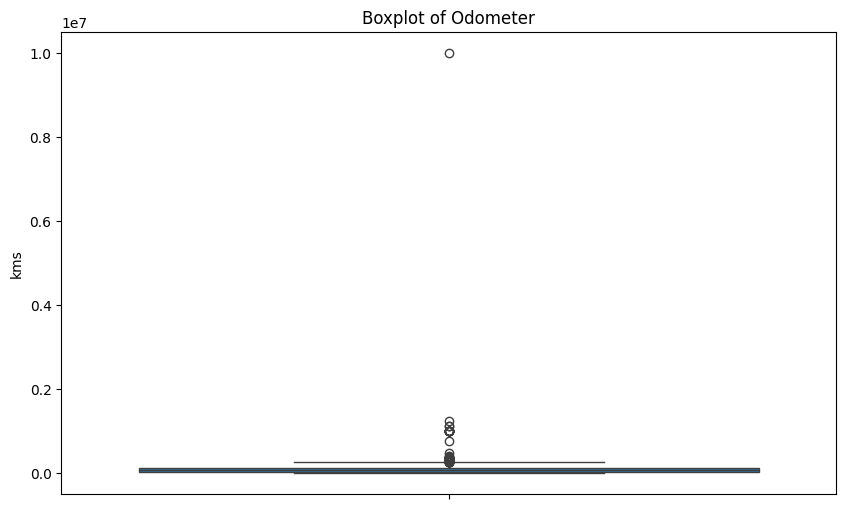

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train.odometer)
plt.title('Boxplot of Odometer')
plt.ylabel('kms')
plt.show()

In [36]:
mask = X_train["odometer"] < 999998
X_train = X_train.loc[mask]
y_train = y_train.loc[mask]

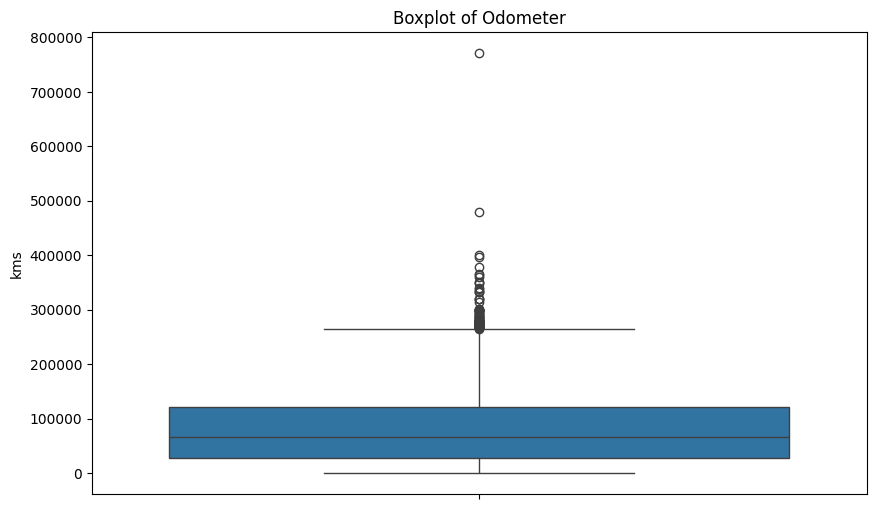

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train.odometer)
plt.title('Boxplot of Odometer')
plt.ylabel('kms')
plt.show()

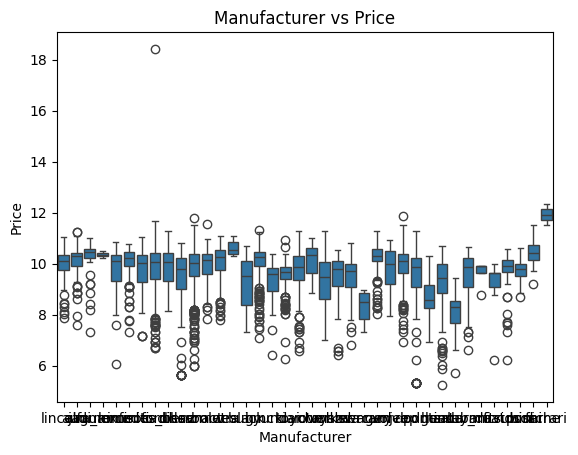

In [38]:
sns.boxplot(x=X_train.manufacturer, y=y)
plt.title('Manufacturer vs Price')
plt.ylabel('Price')
plt.xlabel('Manufacturer')
plt.show()

<Axes: >

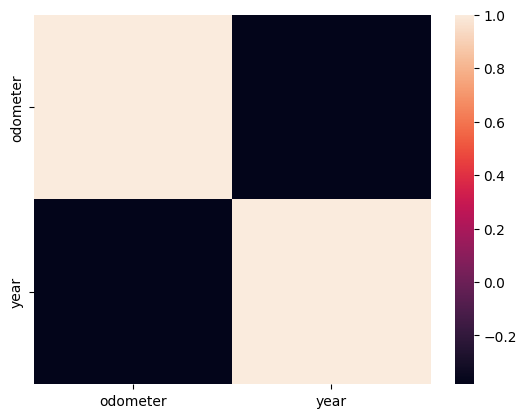

In [39]:
sns.heatmap(X_train[NUM_FEATURES].corr())

### Model Selection / Hyper parameter tuning


In [40]:
#Numeric
num_pipe = Pipeline([
    ('scaler',StandardScaler())
])


In [41]:
#Categocial 
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
     ('encoder', OneHotEncoder(
                    min_frequency=10, 
                    handle_unknown='infrequent_if_exist',
                    sparse_output=False))
])

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, NUM_FEATURES),
        ('cat', cat_pipe, CAT_FEATURES)])

In [43]:
#final pipeline/ Base Ridge model
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
], memory='./cache_dir')

baseline_score = cross_val_score(full_pipeline, X_train, y_train, cv=5)
print(f"Mean Baseline Score: {baseline_score.mean():.4f}")


Mean Baseline Score: 0.6294


In [44]:
#final pipeline/ Base XGBRegressor model 
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
], memory='./cache_dir')

baseline_score = cross_val_score(full_pipeline, X_train, y_train, cv=5)
print(f"Mean Baseline Score: {baseline_score.mean():.4f}")

Mean Baseline Score: 0.7836


In [45]:
#final pipeline/ Base RandomForestRegressor model 
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
], memory='./cache_dir')

baseline_score = cross_val_score(full_pipeline, X_train, y_train, cv=5)
print(f"Mean Baseline Score: {baseline_score.mean():.4f}")

Mean Baseline Score: 0.7949


In [46]:
#final pipeline/ Base LGBMRegressor model 
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor())
], memory='./cache_dir')

baseline_score = cross_val_score(full_pipeline, X_train, y_train, cv=5)
print(f"Mean Baseline Score: {baseline_score.mean():.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 6021, number of used features: 142
[LightGBM] [Info] Start training from score 9.735584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 6021, number of used features: 140
[LightGBM] [Info] Start training from score 9.738154


/home/miguel_garduno/Programacion/ML/used_cars_price_predictor/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/miguel_garduno/Programacion/ML/used_cars_price_predictor/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 6022, number of used features: 134
[LightGBM] [Info] Start training from score 9.741792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 6022, number of used features: 138
[LightGBM] [Info] Start training from score 9.746389


/home/miguel_garduno/Programacion/ML/used_cars_price_predictor/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 6022, number of used features: 136
[LightGBM] [Info] Start training from score 9.736869
Mean Baseline Score: 0.7731


/home/miguel_garduno/Programacion/ML/used_cars_price_predictor/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/miguel_garduno/Programacion/ML/used_cars_price_predictor/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [50]:
#Hyper parameter tuning XGBoost

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
], memory='./cache_dir')

param_distributions = {
    'model__eta': np.arange(0,1,0.15),
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_child_weight' : [0, 1, 5, 10, 20, 30, 50],
    'model__subsample' : [0.25, 0.5, 0.75, 1],
    'model__lambda' : [0, 1, 3, 5, 10]
}

random_search = RandomizedSearchCV(
    xgb_pipeline, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1, 
    random_state=42 
)

random_search.fit(X_train, y_train)

print(f"Best Score: {random_search.best_score_:.4f}")
print(f"Best Params: {random_search.best_params_}")

Best Score: 0.8014
Best Params: {'model__subsample': 1, 'model__min_child_weight': 0, 'model__max_depth': 10, 'model__lambda': 3, 'model__eta': np.float64(0.3)}


In [51]:
#Hyper parameter tuning Random Forest

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
], memory='./cache_dir')

param_distributions = {
    'model__n_estimators': np.arange(100, 1000, 100),    # [100, 200, ..., 900]
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1, 
    random_state=42 
)

random_search.fit(X_train, y_train)

print(f"Best Score: {random_search.best_score_:.4f}")
print(f"Best Params: {random_search.best_params_}")

ValueError: Invalid parameter 'clf' for estimator Pipeline(memory='./cache_dir',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['odometer', 'year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=10,
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color'])])),
                ('model', RandomForestRegressor())]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].